In [143]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [146]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import sklearn
from dateutil.relativedelta import relativedelta
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from utils import model_utils
from utils import db_utils
from utils import iefp_data_utils
from utils import pandas_utils

/opt/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Functions definitions

In [22]:
#Functions definitions
def split_train_test_apps(apps_df,movs_df,test_date,train_start_date,ltu_length):
    selected_apps = model_utils.filter_by_time_range(apps_df,'app_start_date',train_start_date,test_date).sort_values('app_start_date')
    selected_movs = model_utils.filter_by_time_range(movs_df,'movement_event_date',train_start_date,test_date).sort_values('movement_event_date')
    exitted = model_utils.apps_exited_before_date(selected_movs,test_date)
    test_apps = selected_apps[(np.logical_not(selected_apps['table_index'].isin(exitted))) &
                              (pandas_utils.difftime_in_months(test_date,selected_apps['app_start_date']) < ltu_length)]

    train_apps = selected_apps[(np.logical_not(selected_apps['table_index'].isin(test_apps['table_index'])))]
    return train_apps,test_apps

def get_cancellation_date(x):
    return x[x['movement_type'].isin(['cancellation'])].sort_values('movement_event_date').groupby(['application_id']).first().reset_index()[['application_id','movement_event_date']].rename(columns={'movement_event_date': 'cancellation_date'})

def get_placement_date(x):
    return x[x['movement_result'].isin(['ADMITIDO / COLOCADO'])].sort_values('movement_event_date').groupby(['application_id']).first().reset_index()[['application_id','movement_event_date']].rename(columns={'movement_event_date': 'placement_date'})

def get_last_active_date(apps,movs,ref_date):
    apps_cancellations = get_cancellation_date(movs)
    apps_placements = get_placement_date(movs)
    apps_length = apps.merge(apps_cancellations,how='left', left_on='table_index',right_on='application_id').merge(apps_placements,how='left', left_on='table_index',right_on='application_id')[['table_index','app_start_date','cancellation_date','placement_date']]
    apps_length['ref_date'] = ref_date
    apps_length['last_active_date'] = apps_length[['cancellation_date', 'placement_date','ref_date']].min(axis=1)
    
    return apps_length[['table_index','app_start_date','last_active_date']]    

def get_app_length(apps,movs,ref_date=None):
    apps_last_active_date = get_last_active_date(apps,movs,ref_date)
    apps_last_active_date['app_length'] = apps_last_active_date['last_active_date'] - apps_last_active_date['app_start_date']
    
    return apps_last_active_date

def extend_data(apps,movs,labels,ref_date,time_delta):
    if time_delta == None:
        extended_data = apps.merge(labels,on='table_index')[['table_index','app_start_date','ltu']].rename(columns={'table_index':'application_id'})
        extended_data['ref_date'] = ref_date
        extended_data = extended_data[['application_id','app_start_date','ref_date','ltu']]
    else:
        apps_length = get_app_length(apps,movs,ref_date)
        apps_length = apps_length.merge(labels,on='table_index')
        toDataFrame=[]
        for i in xrange(0,apps_length.shape[0]):
            app_id = apps_length['table_index'][i]
            app_st_date = apps_length['app_start_date'][i]
            last_active_date = apps_length['last_active_date'][i]
            app_label = apps_length['ltu'][i]
            count = 0
            curr_ref_date = last_active_date - (int(count)*relativedelta(months=1))
            while (curr_ref_date >= app_st_date):
                toDataFrame.append([app_id,app_st_date,curr_ref_date,app_label])
                count += 1
                curr_ref_date = last_active_date - (int(count)*relativedelta(months=1))
        extended_data = pd.DataFrame(toDataFrame,columns=['application_id','app_start_date','ref_date','ltu'])
        
    return extended_data

def apps_cancelled_within_n_months(x,n=12):
    return x[(x['movement_type'].isin(['cancellation'])) & (x['months_after_app'] < n)]['application_id'].unique()

def apps_placed_within_n_months(x,n=12):
    return x[(x['movement_result'].isin(['ADMITIDO / COLOCADO'])) & (x['months_after_app'] < n)]['application_id'].unique()

def difftime_in_months(timeA,timeB):
    return (timeA-timeB)/np.timedelta64(1, 'M')

def get_ltu_label_on_date(apps,movs,date,ltu_length):
    apps_movs = pandas_utils.filter_by_time_range(movs[movs['application_id'].isin(apps['table_index'])],'movement_event_date',None,date)
    app_date_dict = dict(zip(apps["table_index"],apps["app_start_date"]))
    apps_movs["app_start_date"] = apps_movs["application_id"].map(app_date_dict)
    apps_movs["months_after_app"] = difftime_in_months(apps_movs["movement_event_date"],apps_movs["app_start_date"])
    
    print "Generating LTU/Non-LTU labels"
    cancelled_12mo = apps_cancelled_within_n_months(apps_movs,ltu_length)
    placed_12mo = apps_placed_within_n_months(apps_movs,ltu_length)
    non_ltu_apps = np.unique(np.append(cancelled_12mo,placed_12mo))
    
    labelled_apps = apps.copy()
    labelled_apps['ltu'] = np.logical_not(labelled_apps['table_index'].isin(non_ltu_apps))
    
    return labelled_apps[['table_index','ltu']]


In [5]:
#Demographic feature functions
def apps_cancelled_within_n_months(x,n=12):
    return x[(x['movement_type'].isin(['cancellation'])) & (x['months_after_app'] < n)]['application_id'].unique()

def apps_placed_within_n_months(x,n=12):
    return x[(x['movement_result'].isin(['ADMITIDO / COLOCADO'])) & (x['months_after_app'] < n)]['application_id'].unique()

#Add column to show how many months after the application the movement occurred
def monthdelta(d1, d2):
    delta = 0
    while True:
        mdays = monthrange(d1.year, d1.month)[1]
        d1 += timedelta(days=mdays)
        if d1 <= d2:
            delta += 1
        else:
            break
    return delta

def difftime_in_months(timeA,timeB):
    return (timeA-timeB)/np.timedelta64(1, 'M')


def get_ltu_label(apps,movs):
    app_date_dict = dict(zip(apps["table_index"],apps["app_start_date"]))
    movs["app_start_date"] = movs["application_id"].map(app_date_dict)
    movs["months_after_app"] = difftime_in_months(movs["movement_event_date"],movs["app_start_date"])
    
    print "Generating LTU/Non-LTU labels"
    cancelled_12mo = apps_cancelled_within_n_months(movs)
    placed_12mo = apps_placed_within_n_months(movs)
    
    non_ltu_apps = np.unique(np.append(cancelled_12mo,placed_12mo))
    apps['ltu'] = np.logical_not(apps['table_index'].isin(non_ltu_apps))
    last_data_date = max(apps['app_start_date'])
    apps.loc[difftime_in_months(last_data_date,apps['app_start_date']) < 12,'ltu'] = False
    
    return apps

def findSeason(x):
    month=x.month
    if month in [12,1,2]:
        return "Winter"
    if month in [3,4,5]:
        return "Spring"
    if month in [6,7,8]:
        return "Summer"
    if month in [9,10,11]:
        return "Autumn"

def isPortuguese(x):
    if x=="PT":
        return "PT"
    else:
        return "OT"

def lookingForFirstJob(x):
    if "NOVO" in x:
        return "first_job"
    else:
        return "not_first_job"

def createEducationBuckets(x):
    HS=["12"]
    #SL means  able to write, but no school degree,NS means not able to write
    NR=["NS"]
    U6=["SL","04","06"]
    U11=["09","11"]
    
    #The rest is different kinds of higher degree
    if x in HS:
        return "HS"
    if x in NR:
        return "NR"
    if x in U6:
        return "U6"
    if x in U11:
        return "U11"
    else:
        return "MHS"

def civilStatus(x):
    if x=="S":
        return "S"
    if x=="C":
        return "M"
    else :
        return "O"

def ageBucket(x):
    if x<30:
        return "age<30"
    elif x<50:
        return "30<age<50"
    else:
        return "age>50"

def findMainBucket(profession):
    profDict={0:"Miliatary",1:"Managment",2:"Higer level professionals",3:"Lower level professionals",4:"Office jobs",5:"Sales",
              6:"Fising and farming",7:"Craft and trade",8:"Factory work",9:"Elementary"}
    if pd.isnull(profession):
        return "Unknown"
    else:
        professionInt=int(str(profession)[0:1])
        return profDict[professionInt]
    
def findMainEducation(education):
    eduDict={0:"general",1:"Education",2:"ArtsAndHumanities",3:"SocialScienceTradeAndLaw",4:"STEM",5:"EngineeringAndConstruction",6:"Agriculture",7:"HealthAndSocialProtection",8:"Service",9:"Unkown"}
    if pd.isnull(education):
        return eduDict[9]
    else:
        professionInt=int(str(education)[0:1])
        return eduDict[professionInt]

def preferredJobRegion(letter):
    if letter == "C":
        return "NearJobCenter"
    elif letter == "R":
        return "GreaterLisbonArea"
    elif letter == "N":
        return "Available"
    elif pd.isnull(letter):
        return "Unknown"
    else:
        return "Error"

def employmentPlan(letter):
    if letter == "S":
        return "exists"
    elif letter =="N":
        return "no plan"
    else:
        return "Error"
    
def applicationOrigin(origin):
    if origin == "SIGAE":
        return "SIGAE"
    elif origin == "LSE":
        return "LSE"
    elif pd.isnull(origin):
        return "unknown"
    else:
        return "Error"
    
def intendedRegime(regime):
    if regime == "COMPLETO":
        return "Full-time"
    elif regime == "PARCIAL":
        return "Part-time"
    else:
        return "Error"

def dependentsBucket(n):
    if n == 0:
        return "0"
    elif n == 1:
        return "1"
    elif n == 2:
        return "2"
    elif n == 3:
        return "3"
    elif pd.isnull(n):
        return "Unknown"
    else:
        return "4+"
    
def experienceBuckets(n):
    if pd.isnull(n):
        return "Unknown"
    elif n == 0:
        return "0"
    elif n<24:
        return "<2yr"
    elif n<60:
        return "<5yr"
    elif n<120:
        return "<10yr"
    elif n<240:
        return "<20yr"
    else:
        return "20+yr"


In [35]:
def add_demographics(feature_matrix, apps):
    #Create DF with the demographic features per application_id
    demo_df = apps[["table_index"]]
    
    demo_df["age"] = apps["ute_idade"] #redo age variable to make dyanamic?
    demo_df["gender"] = apps["sexo"]
    demo_df["is_re_registriation"] = apps["candidatura_rinsc"]
    demo_df["soc_ben"] = apps["sub_rsi"]
    demo_df["age2"]=demo_df["age"]**2
    demo_df["age"]=preprocessing.scale(demo_df["age"].astype(float),copy=False)
    demo_df["age2"]=preprocessing.scale(demo_df["age2"].astype(float),copy=False)
    demo_df["season"]=apps["app_start_date"].apply(findSeason)
    demo_df["nationality"]=apps["cnacionalidade"].apply(isPortuguese)
    demo_df["education"]=apps["chabilitacao_escolar"].apply(createEducationBuckets) 
    demo_df["first_job"]=apps["dcategoria"].apply(lookingForFirstJob)
    demo_df["time_since_exit"]=(pd.to_datetime(apps["candidatura_data"])-pd.to_datetime(apps["reinscricao_ult_saida_data"])).dt.days
    demo_df["time_since_exit"].fillna(500,inplace=True)
    demo_df["time_since_exit"]=pd.to_numeric(demo_df["time_since_exit"])
    demo_df["time_since_exit"]=preprocessing.scale(demo_df["time_since_exit"], copy=False)
    demo_df["is_disabled"]=apps["cdeficiencia"].apply(lambda x: "N" if x==0 else "S")
    demo_df["civil_status"]=apps["ute_estado_civil"].apply(civilStatus)
    demo_df["has_course_area"]=apps["darea_curso_tabela_em_activo"]
    demo_df["has_course_area"].fillna(0,inplace=True)
    demo_df["has_course_area"]=demo_df["has_course_area"].apply(lambda x: "S" if x==0 else "N")
    demo_df["has_prof_area"]=apps["darea_formacao_tabela_em_activo"]
    demo_df["has_prof_area"].fillna(0,inplace=True)
    demo_df["has_prof_area"]=demo_df["has_prof_area"].apply(lambda x: "S" if x==0 else "N")
    demo_df["age_category"]=demo_df["age"].apply(ageBucket)
    demo_df["number_dependents"]=apps["ute_nr_pessoas_cargo"].astype(float).fillna(0)
    demo_df["number_dependents"]=preprocessing.scale(demo_df["number_dependents"], copy=False)
    demo_df["experience_intended_prof"]=apps["candidatura_prof_pret_tempo_pratica"].astype(float).fillna(0)
    demo_df["experience_intended_prof"]=preprocessing.scale(demo_df["experience_intended_prof"], copy=False)
    demo_df["experience_prev_prof"]=apps["sit_anterior_prof_tempo_pratica"].astype(float).fillna(0)
    demo_df["experience_prev_prof"]=preprocessing.scale(demo_df["experience_prev_prof"], copy=False) 
    demo_df["intended_prof_1"]=apps["cnp_pretendida"].apply(findMainBucket)
    demo_df["intended_prof_2"]=apps["cpp_pretendida"].apply(findMainBucket)
    demo_df["intended_prof"]=np.where(pd.isnull(demo_df["intended_prof_1"]),demo_df["intended_prof_2"],demo_df["intended_prof_1"])
    del demo_df["intended_prof_1"]
    del demo_df["intended_prof_2"]  
    demo_df["previous_prof_1"]=apps["cnp_anterior"].apply(findMainBucket)
    demo_df["previous_prof_2"]=apps["cpp_anterior"].apply(findMainBucket)
    demo_df["previous_prof"]=np.where(pd.isnull(demo_df["previous_prof_1"]),demo_df["previous_prof_2"],demo_df["previous_prof_1"])
    del demo_df["previous_prof_1"]
    del demo_df["previous_prof_2"]   
    demo_df["training_area"]= apps["carea_formacao_tabela_em_activo"].apply(findMainEducation)   
    demo_df['preferred_location']=apps['candidatura_local_trabalho'].apply(preferredJobRegion)
    demo_df['app_year'] = apps['app_start_date'].apply(lambda x: x.year)
    demo_df['app_month'] = apps['app_start_date'].apply(lambda x: x.month)
    demo_df['employment_plan'] = apps['ute_plano_emprego'].apply(employmentPlan)
    demo_df['prev_employment_plan'] = apps['ute_plano_emprego_anterior'].apply(employmentPlan)
    demo_df['app_origin'] = apps['candidatura_origem'].apply(applicationOrigin)
    demo_df['intended_regime'] = apps['dregime_contrato_pretendido'].apply(intendedRegime)
    demo_df['dependents_bucket'] = apps['ute_nr_pessoas_cargo'].astype(float).apply(dependentsBucket)
    demo_df['exp_intended_prof_buckets'] = apps['candidatura_prof_pret_tempo_pratica'].astype(float).apply(experienceBuckets)
    demo_df['exp_previous_prof_buckets'] = apps['sit_anterior_prof_tempo_pratica'].astype(float).apply(experienceBuckets)
    
    #map to feature matrix using application ID
    feature_matrix = pd.merge(feature_matrix, demo_df, how='left', left_on='application_id', right_on='table_index')
    
    return feature_matrix

In [127]:
def add_dynamic_features(feature_matrix, movs):
    feature_matrix['time_so_far'] = (feature_matrix['ref_date']-feature_matrix['app_start_date']).apply(lambda x: x.days)
    feature_matrix['months_so_far'] = (feature_matrix['ref_date']-feature_matrix['app_start_date']).apply(lambda x: x.days/30)
    
    return feature_matrix

In [117]:
def generate_matrix(extended_data, apps_cropped, movs_cropped, feature_set_list):
    #map movements to application start date
    #app_date_dict = dict(zip(extended_data["table_index"],extended_data["app_start_date"]))
    #movs["app_start_date"] = movs["application_id"].map(app_date_dict)

    print "Generating matrix base" #generate basic matrix including appID, application date, months so far, and label
    feature_matrix = extended_data
    
    if "demographics" in feature_set_list:
        print "Adding demographic features"
        feature_matrix = add_demographics(feature_matrix, apps_cropped)
    
    if "dynamic" in feature_set_list:
        print "Adding dynamic features"
        feature_matrix = add_dynamic_features(feature_matrix, movs_cropped)
    
    #Removing Irrelevant features and create dummies for categorical variables
    irrelevant_features = ['app_start_date','ref_date']
    feature_matrix.drop(irrelevant_features,1,inplace=True)
    feature_matrix = pd.get_dummies(feature_matrix,drop_first=True)
    
    return feature_matrix

# Variable Definitions

In [45]:
#Variables definitions
feature_set_name = 'dynamic'
train_st_date = pd.to_datetime('2013-04-30')
test_st_date = pd.to_datetime('2016-04-30')
test_window_size = pd.Timedelta('365D')
ltu_length = 12
model_id = 'test_model'

# Running Pipeline

In [10]:
#Reading Data from DB
conn = db_utils.connect_to_db()
apps, movs = iefp_data_utils.get_clean_data(conn)

In [11]:
#Splitting train/test datasets
train_apps,test_apps = split_train_test_apps(apps,movs,test_st_date,train_st_date,ltu_length)

In [12]:
#Generate LTU Label
train_labels = get_ltu_label_on_date(train_apps,movs,test_st_date,ltu_length)
test_labels = get_ltu_label_on_date(test_apps,movs,test_st_date + test_window_size,ltu_length)

Generating LTU/Non-LTU labels
Generating LTU/Non-LTU labels


In [23]:
#Extend data
extended_train = extend_data(train_apps,movs,train_labels,test_st_date,pd.Timedelta('30D'))
extended_test = extend_data(test_apps,movs,test_labels,test_st_date,None)

In [128]:
#Generate Features
pd.options.mode.chained_assignment = None
train_matrix = generate_matrix(extended_train,train_apps,movs,['demographics','dynamic'])
test_matrix = generate_matrix(extended_test,test_apps,movs,['demographics','dynamic'])

Generating matrix base
Adding demographic features
Adding dynamic features
Generating matrix base
Adding demographic features
Adding dynamic features


In [131]:
model_obj = model_utils.train_model('rf',train_matrix,{})

In [40]:
model_results = model_utils.test_model('rf',model_obj,test_matrix,model_id)

In [41]:
cutoffs = [
        {"type":"number", "value":50},
        {"type":"number", "value":100},
        {"type":"number", "value":500},
        {"type":"number", "value":1000},
        {"type":"number", "value":2000}
    ]
for k in cutoffs:
    model_performance = model_utils.evaluate_model(model_results, k["type"], k["value"])
    print model_performance.head()

Calculating performance metrics for model: test_model
     model_id k_value  k_type         metric     value
0  test_model      50  number      precision  0.980000
1  test_model      50  number         recall  0.012966
2  test_model      50  number       accuracy  0.459197
3  test_model      50  number  roc_auc_score  0.506323
Calculating performance metrics for model: test_model
     model_id k_value  k_type         metric     value
0  test_model     100  number      precision  0.990000
1  test_model     100  number         recall  0.026197
2  test_model     100  number       accuracy  0.466444
3  test_model     100  number  roc_auc_score  0.512938
Calculating performance metrics for model: test_model
     model_id k_value  k_type         metric     value
0  test_model     500  number      precision  0.942000
1  test_model     500  number         recall  0.124636
2  test_model     500  number       accuracy  0.516307
3  test_model     500  number  roc_auc_score  0.557671
Calculating p

# Error Analysis

In [89]:
def model_metrics(pred,ltu_actual,cutoff_k):
    pred_dict = {'prob': pred,
                'actual': ltu_actual}
    pred_df = pd.DataFrame(pred_dict, index=ltu_actual.index)
    pred_df.sort_values('prob',ascending=False,inplace=True)
    pred_df['pred'] = (([True] * cutoff_k) + ([False] * (pred_df.shape[0]-cutoff_k)))

    true_positive = float(pred_df[(pred_df['pred']) & (pred_df['actual'])].shape[0])
    false_positive = float(pred_df[(pred_df['pred']) & (np.logical_not(pred_df['actual']))].shape[0])
    true_negative = float(pred_df[(np.logical_not(pred_df['pred'])) & (np.logical_not(pred_df['actual']))].shape[0])
    false_negative = float(pred_df[(np.logical_not(pred_df['pred'])) & (pred_df['actual'])].shape[0])
    precision = true_positive/(true_positive + false_positive)
    recall = true_positive/(true_positive + false_negative)
    accuracy = (true_positive+true_negative)/(true_positive+true_negative+false_positive+false_negative)
    roc_auc_score = sklearn.metrics.roc_auc_score(pred_df['actual'], pred_df['pred'])
    #total=len(pred_df)
    ltu=true_positive+false_negative
    #proportion_ltu=ltu*1.0/total
    return (true_positive,true_negative,false_positive,false_negative,precision,recall,accuracy,roc_auc_score)

def get_confmatrix_label(predicted_label,actual_label):
    if predicted_label & actual_label:
        return 'TP'
    elif predicted_label & (not actual_label):
        return 'FP'
    elif (not predicted_label) & (not actual_label):
        return 'TN'
    else:
        return 'FN'

def evaluate_classification(pred,actual_label,cutoff_k):
    pred_dict = {'prob': pred,
                'actual': actual_label}
    pred_df = pd.DataFrame(pred_dict, index=actual_label.index)
    pred_df.sort_values('prob',ascending=False,inplace=True)
    pred_df['pred'] = (([True] * cutoff_k) + ([False] * (pred_df.shape[0]-cutoff_k)))
    pred_df['cm'] = pred_df.apply(lambda x: get_confmatrix_label(x['pred'],x['actual']),axis=1)
    
    return pred_df

In [90]:
#Checking classes order in prediction result
print model_obj.classes_

[ 0.  1.]


In [135]:
classif_eval = evaluate_classification(model_results.loc[:,model_id], model_results.loc[:, 'ltu'], 2000)

In [136]:
classif_eval.head()

,actual,prob,pred,cm
141,True,0.62,True,TP
23,True,0.61,True,TP
12,True,0.60,True,TP
97,False,0.57,True,FP
108,True,0.57,True,TP


In [210]:
test_results = pd.concat([classif_eval,test_matrix],axis=1)[['application_id','cm','months_so_far','prob']].sort_values('prob', ascending=False)

In [211]:
test_results[500:550]

,application_id,cm,months_so_far,prob
544,101308,TP,10,0.25
575,101671,TP,10,0.25
1101,103770,FP,9,0.25
747,102504,TP,9,0.25
552,101866,TP,10,0.25
178,101126,TP,11,0.25
351,102111,TP,11,0.25
3644,115782,TP,3,0.25
520,101256,FP,10,0.25
419,102154,TP,10,0.25


In [212]:
applications_by_months_so_far = test_results.groupby(['months_so_far'])['application_id'].count().reset_index(name='total_count')
applications_by_months_so_far

,months_so_far,total_count
0,0,861
1,1,791
2,2,934
3,3,771
4,4,394
5,5,562
6,6,499
7,7,534
8,8,403
9,9,422


In [213]:
cm_by_months_so_far = test_results.groupby(['cm','months_so_far'])['application_id'].count().reset_index(name='count')
cm_by_months_so_far

,cm,months_so_far,count
0,FN,0,215
1,FN,1,186
2,FN,2,299
3,FN,3,271
4,FN,4,181
5,FN,5,299
6,FN,6,274
7,FN,7,203
8,FN,8,159
9,FN,9,132


In [214]:
norm_cm_by_months_so_far = cm_by_months_so_far.merge(applications_by_months_so_far)
norm_cm_by_months_so_far.head()

,cm,months_so_far,count,total_count
0,FN,0,215,861
1,FP,0,72,861
2,TN,0,515,861
3,TP,0,59,861
4,FN,1,186,791


In [215]:
norm_cm_by_months_so_far['proportion'] = norm_cm_by_months_so_far['count']/norm_cm_by_months_so_far['total_count']
norm_cm_by_months_so_far.head()

,cm,months_so_far,count,total_count,proportion
0,FN,0,215,861,0.249710
1,FP,0,72,861,0.083624
2,TN,0,515,861,0.598142
3,TP,0,59,861,0.068525
4,FN,1,186,791,0.235145


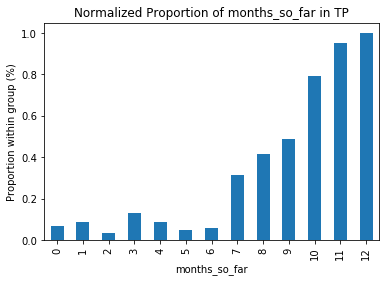

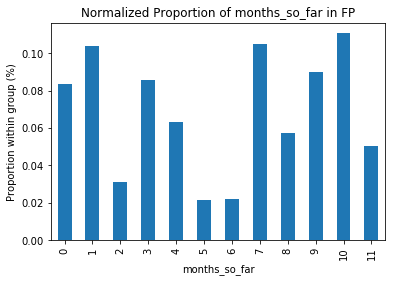

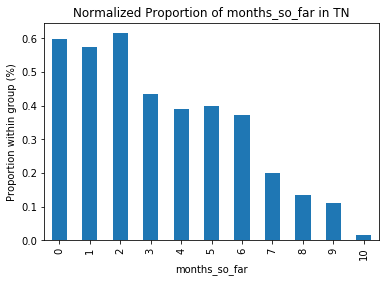

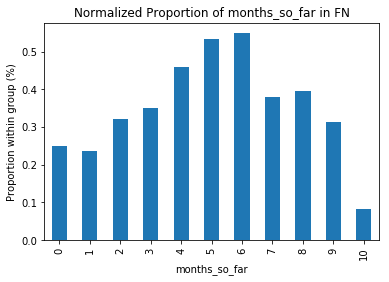

In [216]:
for cm_label in ['TP','FP','TN','FN']:
    cm_hist = norm_cm_by_months_so_far[norm_cm_by_months_so_far['cm'] ==  cm_label][['months_so_far','proportion']]
    cm_hist.plot(
        x='months_so_far',
        y='proportion',
        kind='bar',
        legend=False,
        title="Normalized Proportion of months_so_far in " + cm_label).set_ylabel('Proportion within group (%)')

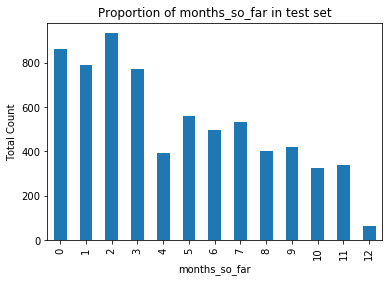

In [189]:
applications_by_months_so_far.plot(
        x='months_so_far',
        y='total_count',
        kind='bar',
        legend=False,
        title="Proportion of months_so_far in test set").set_ylabel('Total Count')

In [129]:
test_matrix.time_so_far.describe()

count    6899.000000
mean      148.807798
std       101.907016
min         1.000000
25%        61.000000
50%       130.000000
75%       228.000000
max       362.000000
Name: time_so_far, dtype: float64

In [130]:
test_matrix.months_so_far.describe()

count    6899.000000
mean        4.473112
std         3.419152
min         0.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        12.000000
Name: months_so_far, dtype: float64

In [69]:
classif_eval.groupby('cm').count()

,actual,prob,pred
cm,,,
FN,2246,2246,2246
FP,467,467,467
TN,2653,2653,2653
TP,1533,1533,1533


In [ ]:
#Analyze Distribution of months since application in TP and FN


In [54]:
classif_eval.shape

(6899, 3)

In [53]:
classif_eval.head()

,actual,prob,pred
141,True,0.62,True
23,True,0.61,True
12,True,0.60,True
97,False,0.57,True
108,True,0.57,True


# Testing Features Matrix

In [32]:
train_matrix.columns.to_series().groupby(train_matrix.dtypes).groups

{dtype('bool'): Index([u'ltu'], dtype='object'),
 dtype('uint8'): Index([                                u'gender_M',
                           u'is_re_registriation_S',
                                       u'soc_ben_S',
                                   u'season_Spring',
                                   u'season_Summer',
                                   u'season_Winter',
                                  u'nationality_PT',
                                   u'education_MHS',
                                    u'education_NR',
                                   u'education_U11',
                                    u'education_U6',
                         u'first_job_not_first_job',
                                   u'is_disabled_S',
                                  u'civil_status_O',
                                  u'civil_status_S',
                               u'has_course_area_S',
                                 u'has_prof_area_S',
                        u'intended

In [21]:
test_matrix.head()

,application_id,app_start_date,ref_date,ltu,time_so_far,months_so_far,table_index,age,gender,is_re_registriation,...,preferred_location,app_year,app_month,employment_plan,prev_employment_plan,app_origin,intended_regime,dependents_bucket,exp_intended_prof_buckets,exp_previous_prof_buckets
0,100444,2015-05-04,2016-04-30,True,362 days,11.893468,100444,0.886014,M,S,...,NearJobCenter,2015,5,no plan,exists,SIGAE,Full-time,4+,<20yr,<20yr
1,100423,2015-05-04,2016-04-30,True,362 days,11.893468,100423,0.497191,F,S,...,NearJobCenter,2015,5,no plan,exists,SIGAE,Full-time,2,<2yr,<2yr
2,101026,2015-05-04,2016-04-30,True,362 days,11.893468,101026,1.663660,M,N,...,Unknown,2015,5,no plan,no plan,SIGAE,Full-time,Unknown,20+yr,20+yr
3,100823,2015-05-04,2016-04-30,True,362 days,11.893468,100823,-1.058102,M,S,...,NearJobCenter,2015,5,no plan,exists,SIGAE,Full-time,0,<2yr,<2yr
4,100818,2015-05-04,2016-04-30,True,362 days,11.893468,100818,-1.291396,F,S,...,NearJobCenter,2015,5,exists,exists,SIGAE,Part-time,0,<2yr,<2yr


# Testing Extended Datasets

In [17]:
extended_train.head()

,application_id,ref_date
0,73209,2015-10-29
1,73209,2015-09-29
2,73209,2015-08-29
3,73209,2015-07-29
4,73209,2015-06-29


In [ ]:
extended_test.head()

In [44]:
extended_train[['application_id','ltu']].drop_duplicates().ltu.sum()

8355

In [45]:
extended_test[['application_id','ltu']].drop_duplicates().ltu.sum()

3779

In [33]:
train_labels.groupby('ltu').count()/train_labels.shape[0]

,table_index
ltu,
False,0.728434
True,0.271566


In [34]:
test_labels.groupby('ltu').count()/test_labels.shape[0]

,table_index
ltu,
False,0.452239
True,0.547761


In [ ]:
train_app_length = get_app_length(train_apps,movs,test_st_date)

In [ ]:
train_app_length.describe()

In [ ]:
test_app_length = get_app_length(test_apps,movs,test_st_date)

In [ ]:
test_app_length.describe()

In [42]:
train_apps.shape

(30766, 62)

In [43]:
test_apps.shape

(6899, 62)